### 01. 형태소 분석엔진 설치 (Colab)

In [2]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
!bash Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 138 (delta 26), reused 22 (delta 8), pack-reused 91
Receiving objects: 100% (138/138), 1.72 MiB | 20.42 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Installing konlpy.....
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 48.9 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2023-09-19 01:24:22--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22cd:e0db
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuse

### 02. 패키지 준비하기

In [26]:
import os
import numpy as np
import seaborn as sb
import requests

from os import sys
from pandas import DataFrame
from pandas import read_excel
from konlpy.tag import Mecab
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### 03. 데이터셋 준비하기

In [6]:
origin = read_excel("./news.xlsx")
origin.head()

,category,content
0,"IT,과학","“갤럭시S9 20만 원대, 아이폰6S 0원!” 모비톡, 가정의 달 이벤트 '갤럭시노..."
1,"IT,과학",'모비톡' 단독으로 진행되는 5월 가정의 달 이벤트에 이용자들의 폭발적인 반응이 나...
2,"IT,과학","이 밖에도 '모비톡'은 '갤럭시노트8', 'V30' 구매 시 '닌텐도 스위치'를 증..."
3,"IT,과학","LG 그램’, 100만대 판매기념 한정판 나왔다 LG전자가 ‘그램’ 노트북 누적판매..."
4,"IT,과학",LG전자는 베스트샵 등 주요 매장에서 23일부터 그램 한정판 500대를 판매한다고 ...


### 불용어 데이터셋


In [7]:
r = requests.get("https://data.hossam.kr/korean_stopwords.txt")
r.encoding = 'utf-8'
stopwords = r.text.split("\n")
print(stopwords)

['이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하', '때문', '그것', '두', '말하', '알', '그러나', '받', '못하', '일', '그런', '또', '문제', '더', '사회', '많', '그리고', '좋', '크', '따르', '중', '나오', '가지', '씨', '시키', '만들', '지금', '생각하', '그러', '속', '하나', '집', '살', '모르', '적', '월', '데', '자신', '안', '어떤', '내', '내', '경우', '명', '생각', '시간', '그녀', '다시', '이런', '앞', '보이', '번', '나', '다른', '어떻', '여자', '개', '전', '들', '사실', '이렇', '점', '싶', '말', '정도', '좀', '원', '잘', '통하', '소리', '놓', '!', '"', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '...', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ';', '<', '=', '>', '?', '@', '\\', '^', '_', '`', '|', '~', '·', '—', '——', '‘', '’', '“', '”', '…', '、', '。', '〈', '〉', '《', '》', '가', '가까스로', '가령', '각', '각각', '각자', '각종', '갖고말하자면', '같다', '같이', '개의치않고', '거니와', '거바', '거의', '것', '것과 같이', '것들', '게다가', '게우다', '겨우', '견지에서', '결과에 이르다', '결국', '결론을 낼 수 있다', '겸사겸사', '고려하면', '고로', '곧', '공

### 04. 데이터 전처리
#### 뉴스기사에서 영어, 특수문자를 제거하고 한글만 남기기

In [8]:
df = origin.copy()

# 한글을 제외한 나머지 글자들을 빈 문자열로 대체
df['content'] = df['content'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)

# document 컬럼의 데이터들 중에서 빈 문자열만 존재하는 항목은 결측치로 대체
df['content'].replace('', np.nan, inplace=True)

# 전체 데이터 셋 크기 확인
print('데이터 크기: ', df['content'].shape)

# 결측치 확인
print('결측치 크기: ', df['content'].isna().sum())


데이터 크기:  (75264,)
결측치 크기:  513


#### 결측치 제거

In [9]:
df.dropna(inplace=True)
print('결측치 크기: ', df['content'].isna().sum())


결측치 크기:  0


#### 종속변수 라벨링
#### 종속변수 값의 종류


In [10]:
category = list(df['category'].unique())
category


['IT,과학', '경제', '사회', '생활,문화', '세계', '정치']

#### 종속변수 값의 종류를 딕셔너리로 변환

In [11]:
cate_dict = {}

for i, v in enumerate(category):
    cate_dict[v] = i

cate_dict

{'IT,과학': 0, '경제': 1, '사회': 2, '생활,문화': 3, '세계': 4, '정치': 5}

#### 종속변수 라벨링


In [12]:
df['category'] = df['category'].map(cate_dict)
df['category'].value_counts()

5    16152
1    14723
4    13668
2    12500
0    10947
3     6761
Name: category, dtype: int64

#### 뉴스기사 형태소 분석

In [27]:
if sys.platform == 'win32':
    mecab = Mecab(dicpath="C:\\mecab\\mecab-ko-dic")
else:
    mecab = Mecab()

# 문장내 형태소들을 저장할 리스트
word_set = []

# 덧글 내용에 대해 반복 처리
for i, v in enumerate(df['content']):
    # 덧글 하나에 대한 형태소 분석
    morphs = mecab.morphs(v)
    # print(morphs)
    # if i > 5:
    #     break

    # 형태소 분석 결과에서 불용어를 제외한 단어만 별도의 리스트로 생성
    confirm_words = []
    for j in morphs:
        if j not in stopwords:
            confirm_words.append(j)

    # 불용어를 제외한 형태소 리스트를 통째로 word_set에 저장함
    # -> word_set은 2차원 리스트가 된다. 1차원이 덧글 단위임
    word_set.append(confirm_words)

# 상위 3건만 출력해서 확인
word_set[:3]


[['갤럭시',
  '만',
  '원대',
  '아이폰',
  '모비',
  '톡',
  '가정',
  '달',
  '벤트',
  '갤럭시',
  '노트',
  '갤럭시',
  '갤럭시',
  '갤럭시',
  '갤럭시',
  '엣지',
  '아이폰',
  '아이폰',
  '아이폰',
  '다양',
  '휴대폰',
  '정보',
  '가득',
  '스마트폰',
  '공동',
  '구매',
  '거래',
  '플',
  '모비',
  '톡',
  '가정',
  '달',
  '벤트',
  '화제',
  '다'],
 ['모비',
  '톡',
  '단독',
  '진행',
  '는',
  '가정',
  '달',
  '벤트',
  '이용자',
  '폭발',
  '인',
  '반응',
  '나타나',
  '고',
  '다',
  '고가',
  '인기',
  '스마트폰',
  '파격',
  '판매',
  '한다는',
  '커뮤니티',
  '카페',
  '중심',
  '화제',
  '모으',
  '고',
  '는',
  '특히',
  '갤럭시',
  '만',
  '대',
  '아이폰',
  '는',
  '할',
  '부',
  '원금',
  '앞세워',
  '안드로이드',
  '인기',
  '기종',
  '중심',
  '큰',
  '폭',
  '할인',
  '펼치',
  '는',
  '게',
  '주된',
  '요인',
  '꼽힌다',
  '모비',
  '톡',
  '관계자',
  '면',
  '고마운',
  '감사',
  '마음',
  '담',
  '선물',
  '할',
  '기회',
  '은',
  '가정',
  '달',
  '맞',
  '공격',
  '인',
  '마케팅',
  '진행',
  '고',
  '다며',
  '독보',
  '인',
  '통신비',
  '절약',
  '플',
  '로서',
  '도',
  '최선',
  '다',
  '겠',
  '다고',
  '밝혔',
  '다'],
 ['밖',
  '도',
  '모비',
  '톡',
  '은',
  '갤럭시',
 

### 형태소 토큰화

#### 전체 단어에 대한 토큰화

In [28]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(word_set)
print(f'전체 단어수: {len(tokenizer.word_index)}')

전체 단어수: 31206


3회 이상 자주 등장하는 단어의 수 구하기


In [29]:
# 사용 빈도가 높다고 판단할 등장 회수
threshold = 3

# 전체 단어의 수
total_cnt = len(tokenizer.word_index)

# 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트할 값
rare_cnt = 0

# 훈련 데이터의 전체 단어 빈도수 총 합
total_freq = 0

# 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합
rare_freq = 0

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 미만인 희귀 단어의 수: %s' % (threshold, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 자주 등장하는 단어 집합의 크기 구하기 -> 이 값이 첫 번째 학습층의 input 수가 된다.
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :', vocab_size)

단어 집합(vocabulary)의 크기 : 31206
등장 빈도가 3번 미만인 희귀 단어의 수: 11976
단어 집합에서 희귀 단어의 비율: 38.3772351470871
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7819031788492435
단어 집합의 크기 : 19232


자주 등장하는 단어를 제외한 나머지 단어를 OOV로 처리하여 최종 토큰화 진행


In [30]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(word_set)
token_set = tokenizer.texts_to_sequences(word_set)
print('토큰의 크기 :', len(token_set))

토큰의 크기 : 74751


토큰화 결과의 길이가 0인 항목 찾기


In [31]:
# 토큰화 결과 길이가 0인 항목의 index 찾기
drop_target_index = []

for i,v in enumerate(token_set):
  if len(v) <1:
    drop_target_index.append(i)

print('길이가 0인 항목의 수: ', len(drop_target_index))

print("길이가 0인 항목의 인덱스 모음:", drop_target_index)

길이가 0인 항목의 수:  95
길이가 0인 항목의 인덱스 모음: [1685, 1693, 14341, 14781, 14783, 14786, 14792, 15228, 17997, 18150, 18152, 18155, 18161, 19637, 21822, 21824, 21827, 21833, 24126, 24128, 24131, 24137, 24292, 32087, 32090, 32095, 32099, 32106, 32111, 32114, 32119, 32120, 32122, 32123, 32125, 32127, 32128, 32130, 32131, 32133, 32134, 32136, 32137, 32139, 32141, 32142, 32144, 32146, 32148, 32149, 32151, 32152, 32154, 32156, 32157, 32159, 32161, 32162, 32164, 32166, 32168, 32170, 32172, 32173, 32175, 32177, 32179, 32181, 32183, 32184, 32186, 32188, 32190, 32192, 32194, 32195, 32197, 32198, 32200, 32201, 32203, 32205, 32207, 32208, 32210, 32212, 38888, 63724, 63733, 66155, 66164, 68153, 68162, 69475, 69484]


토큰화 결과의 길이가 0인 항목 삭제하기


In [32]:
token_set2 = np.asarray(token_set, dtype="object")


In [33]:
# 토큰 결과에서 해당 위치의 항목들을 삭제한다.
fill_token_set = np.delete(token_set2, drop_target_index, axis=0)

# 종속변수에서도 같은 위치의 항목들을 삭제해야 한다.
label_set = np.delete(df['category'].values, drop_target_index, axis=0)

print("독립변수(덧글) 데이터 수: ", len(fill_token_set))
print("종속변수(레이블) 데이터 수: ", len(label_set))

독립변수(덧글) 데이터 수:  74656
종속변수(레이블) 데이터 수:  74656


#05. 탐색적 데이터 분석
1) 각 문장별로 몇 개의 단어를 포함하고 있는지 측정

In [34]:
word_counts = []

for s in fill_token_set:
    word_counts.append(len(s))

max_word_count = max(word_counts)
min_word_count = min(word_counts)

print('기사의 최대 단어수 :',max_word_count)
print('기사의 최소 단어수 :',min_word_count)

기사의 최대 단어수 : 252
기사의 최소 단어수 : 1


2) 히스토그램으로 단어 분포 수 확인


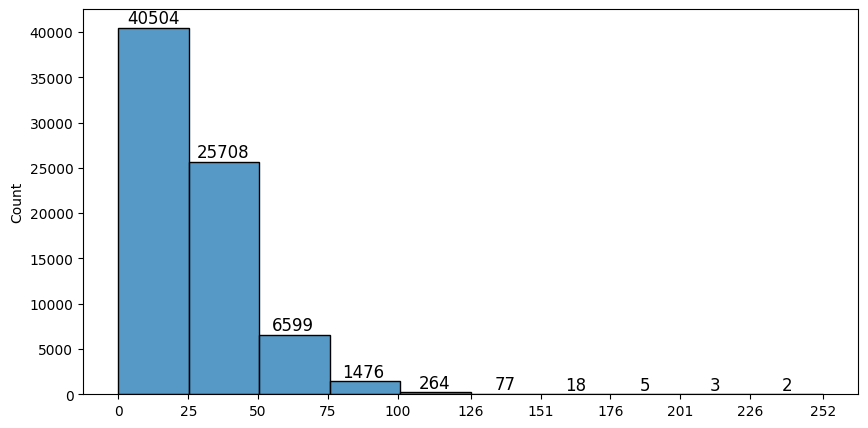

In [35]:
# 히스토그램의 범위 산정
hist_values, hist_bins = np.histogram(word_counts, range=(0, max_word_count), bins=10)
hist_bins = hist_bins.astype(np.int64)

plt.figure(figsize=(10, 5))
sb.histplot(word_counts, bins=10, binrange=(0, max_word_count))
plt.xticks(hist_bins, hist_bins)

for i, v in enumerate(hist_values):
    x = hist_bins[i] + ((hist_bins[i+1] - hist_bins[i]) / 2)
    plt.text(x=x, y=v, s=str(v), fontsize=12, verticalalignment='bottom', horizontalalignment='center')

plt.show()
plt.close()


#06. 데이터 셋 분할하기
랜덤시드 고정

In [36]:
np.random.seed(777)


패딩처리


In [37]:
max_word_count = max(word_counts)
pad_token_set = pad_sequences(fill_token_set, maxlen=max_word_count)
pad_token_set

array([[   0,    0,    0, ..., 8253, 2756,    3],
       [   0,    0,    0, ...,   10,   28,    3],
       [   0,    0,    0, ..., 1919,    6,    3],
       ...,
       [   0,    0,    0, ...,    9, 1615,    3],
       [   0,    0,    0, ...,   24,  126,    1],
       [   0,    0,    0, ...,  186,    5,    3]], dtype=int32)

훈련데이터와 검증데이터로 분할하기


In [38]:
x_train, x_test, y_train, y_test = train_test_split(pad_token_set, label_set, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((52259, 252), (22397, 252), (52259,), (22397,))

종속변수(Label)에 대한 one-hot-encoding


In [39]:
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
print(y_test_one_hot)

[[0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


#07. 모델 개발
모델 정의

In [40]:
#모델 개발
model = Sequential()

# input_dim의 크기는 토큰 생성시 지정한 최대 단어수(vocab_size)와 동일하게 설정
# output_dim의 크기는 input_dim보다 작은 값 중에서 설정
model.add(Embedding(input_dim = vocab_size, output_dim = 64))
model.add(GRU(256))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1230848   
                                                                 
 gru (GRU)                   (None, 256)               247296    
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                                 
Total params: 1479686 (5.64 MB)
Trainable params: 1479686 (5.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


학습하기


In [41]:
# 파일이 저장될 경로(폴더) 지정 (한글,공백이 포함되어 있을 경우 에러 발생함)
if sys.platform == 'win32':
    checkpoint_path = "D:\\tensorflow_checkpoint\\cp-{epoch:04d}-ckpt"
else:
    checkpoint_path = "./model07-cp-{epoch:04d}-ckpt"

result = model.fit(x_train, y_train_one_hot, epochs=500, validation_data=(x_test, y_test_one_hot), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)
])


Epoch 1/500
1634/1634 [==============================] - ETA: 0s - loss: 0.6069 - acc: 0.7796
Epoch 1: val_loss improved from inf to 0.31115, saving model to ./model07-cp-0001-ckpt
1634/1634 [==============================] - 151s 87ms/step - loss: 0.6069 - acc: 0.7796 - val_loss: 0.3111 - val_acc: 0.8930 - lr: 0.0010
Epoch 2/500
1634/1634 [==============================] - ETA: 0s - loss: 0.2284 - acc: 0.9206
Epoch 2: val_loss improved from 0.31115 to 0.28115, saving model to ./model07-cp-0002-ckpt
1634/1634 [==============================] - 51s 31ms/step - loss: 0.2284 - acc: 0.9206 - val_loss: 0.2812 - val_acc: 0.9074 - lr: 0.0010
Epoch 3/500
1634/1634 [==============================] - ETA: 0s - loss: 0.1530 - acc: 0.9439
Epoch 3: val_loss did not improve from 0.28115
1634/1634 [==============================] - 44s 27ms/step - loss: 0.1530 - acc: 0.9439 - val_loss: 0.2838 - val_acc: 0.9083 - lr: 0.0010
Epoch 4/500
1634/1634 [==============================] - ETA: 0s - loss: 0.120

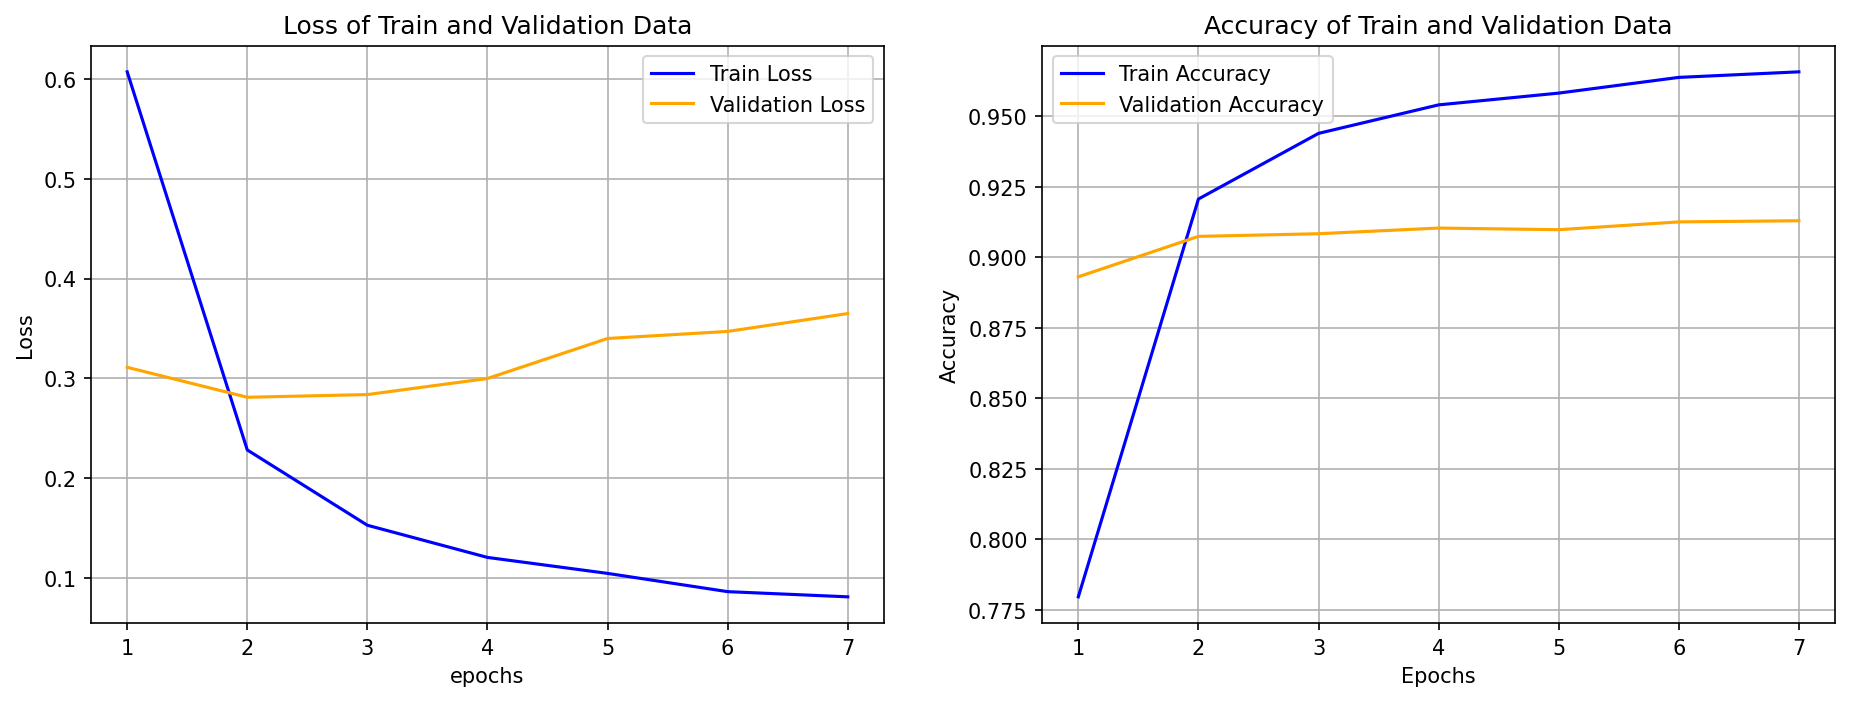

1634/1634 [==============================] - 12s 7ms/step - loss: 0.0772 - acc: 0.9681
최종 훈련 손실률: 0.077203, 최종 훈련 정확도: 0.968063
700/700 [==============================] - 5s 8ms/step - loss: 0.3649 - acc: 0.9129
최종 검증 손실률: 0.364934, 최종 검증 정확도: 0.912890


In [46]:
# 데이터 프레임으로 반복횟수 추가해서 생성
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)

# 그래프를 그리기 위한 객체 생성
#----------------------------------------------------
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5), dpi = 150)

# 1) 훈련 및 검증 손실 그리기
# ----------------------------------------------------
sb.lineplot(x=result_df.index, y = 'loss', data = result_df, color = 'blue', label = 'Train Loss', ax = ax1)
sb.lineplot(x=result_df.index, y = 'val_loss', data = result_df, color = 'orange', label = 'Validation Loss', ax = ax1)
ax1.set_title("Loss of Train and Validation Data")
ax1.set_xlabel('epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 정확도 그리기
# -------------------------------------------------
sb.lineplot(x=result_df.index, y = 'acc', data = result_df, color = 'blue', label = "Train Accuracy", ax = ax2)
sb.lineplot(x=result_df.index, y = 'val_acc', data = result_df, color = 'orange',label= 'Validation Accuracy', ax = ax2)
ax2.set_title("Accuracy of Train and Validation Data")
ax2.set_xlabel('Epochs')
ax2.set_ylabel("Accuracy")
ax2.grid()
ax2.legend()

plt.show()
plt.close()

evaluate1 = model.evaluate(x_train, y_train_one_hot)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" %(evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test_one_hot)
print('최종 검증 손실률: %f, 최종 검증 정확도: %f' %(evaluate2[0], evaluate2[1]))


In [47]:
result = model.predict(x_train, batch_size=10)
data_count, case_count = result.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
result

5226/5226 [==============================] - 25s 5ms/step
52259개의 검증 데이터가 6개의 경우의 수를 갖는다.


array([[2.65689960e-06, 1.33730709e-05, 4.95850982e-04, 3.25250858e-06,
        9.99469578e-01, 1.52182665e-05],
       [4.68296548e-08, 4.46949500e-09, 1.01852935e-08, 4.26972191e-09,
        3.40461903e-09, 9.99999881e-01],
       [8.77568368e-07, 9.99901533e-01, 8.30341451e-05, 1.11801437e-05,
        8.52223252e-07, 2.65523568e-06],
       ...,
       [3.81328300e-06, 8.24246672e-06, 2.09057271e-06, 7.17787916e-05,
        9.99912381e-01, 1.67816529e-06],
       [3.73830318e-08, 9.82185156e-06, 6.87004160e-07, 7.52317248e-08,
        9.99982834e-01, 6.57203645e-06],
       [3.29565992e-08, 2.60135948e-08, 9.96751965e-07, 8.55301274e-10,
        9.25516801e-08, 9.99998808e-01]], dtype=float32)

In [49]:
f_results = result.flatten()
f_results

array([2.6568996e-06, 1.3373071e-05, 4.9585098e-04, ..., 8.5530127e-10,
       9.2551680e-08, 9.9999881e-01], dtype=float32)

In [63]:
f_y_train = y_train_one_hot.flatten()
f_y_train

array([0., 0., 0., ..., 0., 0., 1.], dtype=float32)

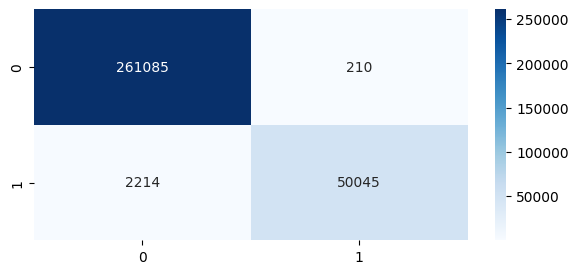

In [64]:
kdf = DataFrame({
    'train': f_y_train,
    'pred' : np.round(f_results)
})

kdf['pred'] = kdf['pred'].astype('int')

cm = confusion_matrix(kdf['train'], kdf['pred'])

plt.figure(figsize=(7, 3))
sb.heatmap(cm, annot = True, fmt = 'd',cmap = 'Blues')
plt.show()
plt.close()